# HW5_keras RNN
## 201823871 박지헌
  
  
## 1. keras embedding을 이용한 문서 분류


In [4]:
import nltk
nltk.download('movie_reviews')
  

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\82104\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.


True

In [5]:
from nltk.corpus import movie_reviews
fileids = movie_reviews.fileids() #movie review data에서 file id를 가져옴

reviews = [movie_reviews.raw(fileid) for fileid in fileids] #file id를 이용해 raw text file을 가져옴
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids] 
#file id를 이용해 label로 사용할 category 즉 positive와 negative 정보를 순서대로 가져옴

print('Reviews count:', len(reviews))
print('Length of the first review:', len(reviews[0]))
print('Labels:', set(categories))

Reviews count: 2000
Length of the first review: 4043
Labels: {'neg', 'pos'}


In [7]:
from keras.preprocessing.text import Tokenizer

max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)

X = tokenizer.texts_to_sequences(reviews)
# 일반적으로 0이면 unknown, 즉 전체단어의 수가 10000개 - num_words가 넘을 경우, index가 10000-1(for unknown)을 넘어가는 단어는 0으로 처리함
#onehot_train = tokenizer.texts_to_matrix(X_train, mode='binary')

print('num of tokens:', len(tokenizer.word_index))

num of tokens: 43296


In [8]:
bow = tokenizer.texts_to_matrix(reviews, mode='binary')
bow.shape

(2000, 10000)

In [9]:
from keras import preprocessing

maxlen = 500

X = preprocessing.sequence.pad_sequences(X, maxlen=maxlen, truncating='pre')
print(X[0])

[  38    1  328   52   20  769   52   20   52   20    2    4  910  114
   52   20 5277    4 1386  171    8  632    3   63    4    9    6  321
   25 1957  143   18 2926  120  301  254    5 9489    2   15  150  143
    3  102   16   44   35    9   91    6  256  103    1  164 2851  100
    3  100  208   18   72  259    4 4077   42   82    2   94   45    6
   14  247  954  353   37  613  294   14  133  801    5 3146   16    9
  138    5  257    5 3146    9  308  313   64  369  493  226    3   75
   36   86  171  439 2795   46   56 1747    7    1 5675   25   92    1
 1280  204    6    8    1 4078    3   18  158 5676   19 1711   38   14
   39   62  175 4079   63    4    9   40   21    1  268   84  212   39
   35    4    1   82    8  197  442    5   86    2   98  251    4  261
   16    9  137  248    1   86    1   15   35    8   43  439   18  618
    1 1486  311   11  121   38   14    6    8   34  167  245   86  276
    8    1  161    6   55    9   56  141   36   20  284    1  801    5
 2016 

In [10]:
label_dict = {'pos':0, 'neg':1}
y = [label_dict[c] for c in categories]
print(y[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [11]:
from sklearn.model_selection import train_test_split #sklearn에서 제공하는 split 함수를 사용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
# sklearn의 train_test_split 함수는 먼저 data set을 shuffle하고 주어진 비율에 따라 train set과 test set을 나눠 줌
# 위에서는 reviews를 X_train과 X_test로 8:2의 비율로 나누고, categories를 y_train과 y_test로 나눔
# 이 때 X와 y의 순서는 동일하게 유지해서 각 입력값과 label이 정확하게 match되도록 함
# random_state는 shuffle에서의 seed 값으로, 지정한 경우 항상 동일한 결과로 shuffle이 됨

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]


In [14]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
import numpy as np

model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
y_train = np.array(y_train)
history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16001     
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 1s 80ms/step - loss: 0.6930 - acc: 0.5250 - val_loss: 0.6906 - val_acc: 0.5531
Epoch 2/30
5/5 [==============================] - 0s 45ms/step - loss: 0.6410 - acc: 0.8719 - val_loss: 0.6882 - val_acc: 0.5656
Epoch 3/30
5/5 [==============================] - 0s 40ms/step - loss: 0.5969 - acc: 0.9391 - val_loss: 0.6851 - val_acc

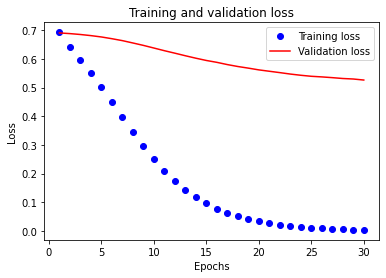

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
score = model.evaluate(np.array(X_test), np.array(y_test))
print(score)

13/13 [==============================] - 0s 2ms/step - loss: 0.5362 - acc: 0.7125
[0.5362428426742554, 0.7124999761581421]


In [20]:
from keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(max_words, 32))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/30
5/5 [==============================] - 4s 603ms/step - loss: 0.6934 - acc: 0.4852 - val_loss: 0.6927 - val_acc: 0.5281
Epoch 2/30
5/5 [==============================] - 3s 636ms/step - loss: 0.6893 - acc: 0.6664 - val_loss: 0.6914 - val_acc: 0.5500
Epoch 3/30
5/5 [==============================] - 3s 653ms/step - loss: 0.6801 - acc: 0.7688 - val_loss: 0.6873 - val_acc: 0.5781
Epoch 4/30
5/5 [==============================] - 3s 665ms/step - loss: 0.6523 - acc: 0.8062 - val_loss: 0.9420 - val_acc: 0.5063
Epoch 5/30
5/5 [==============================] - 3s 622ms/step - loss: 0.6503 - acc: 0.8188 - val_loss: 0.6444 - val_acc: 0.6594
Epoch 6/30
5/5 [==============================] - 4s 783ms/step - loss: 0.5421 - acc: 0.8117 - val_loss: 0.6536 - val_acc: 0.6313
Epoch 7/30
5/5 [==============================] - 4s 739ms/step - loss: 0.5321 - acc: 0.9062 - val_loss: 0.5784 - val_acc: 0.7469
Epoch 8/30
5/5 [==============================] - 4s 751ms/step - loss: 0.3926 - acc: 0.92

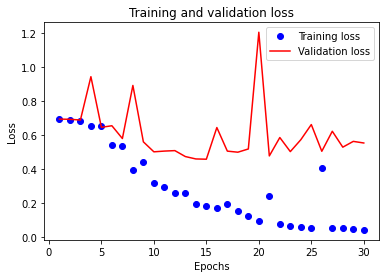

In [22]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

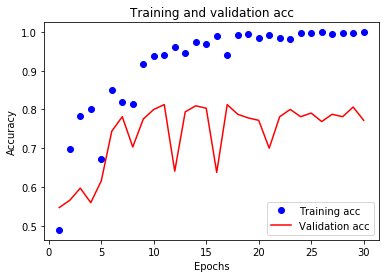

In [13]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [24]:
score = model.evaluate(np.array(X_test), np.array(y_test))
print(score)

13/13 [==============================] - 1s 38ms/step - loss: 0.5672 - acc: 0.7775
[0.5672404170036316, 0.7774999737739563]
